In [304]:
import pandas as pd
import numpy as np
import _pickle as pkl
from sklearn.model_selection import train_test_split
import re
import os
from bs4 import BeautifulSoup
from collections import Counter
from string import punctuation
from scipy.sparse import hstack
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk import pos_tag, word_tokenize

# Test and Train

In [305]:
df = pd.read_csv('./datasets/train.csv')
X = df.loc[:, 'Page content'].to_numpy()
y = df.loc[:,'Popularity'].to_numpy()

### Tokenizer

In [306]:
POSITIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'positive-words.txt')
NEGATIVE_WORDS = os.path.join(os.getcwd(), 'datasets', 'negative-words.txt')
pos_words = []
neg_words = []


for line in open(POSITIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    pos_words.append(word)

for line in open(NEGATIVE_WORDS, 'r').readlines()[35:]:
    word = line.rstrip()
    neg_words.append(word)

In [307]:
stop = stopwords.words('english')

def tokenizer_stem_neg(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in neg_words and re.match('[a-zA-Z]+', w)]

def tokenizer_stem_pos(text):
    stemmer = LancasterStemmer()
    return [stemmer.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w in pos_words and re.match('[a-zA-Z]+', w)]
def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split(r'\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

### Out of mem 

In [308]:
def get_stream(path, size):
    for chunk in pd.read_csv(path, chunksize=size):
        yield chunk
batch_size = 1024
iters = int((27643+batch_size-1)/(batch_size*2))

In [309]:
stream = get_stream(path='./datasets/train.csv', size=batch_size)
idx = 0
X_train, y_train = None, None
batch_X, batch_y = None, None
for z in range(iters):
    batch = next(stream)
    if(idx==0):
        X_train= batch['Page content']
        y_train = batch['Popularity']
        idx+=1
    else:
        X_train = np.concatenate((X_train, batch['Page content']))
        y_train = np.concatenate((y_train, batch['Popularity']))
    batch = next(stream)

### Features Selection


In [310]:
import math

author_score =dict()
author_num = dict()
channel_score = dict()
channel_num = dict()
topic_score = dict()
topic_num = dict()
avg_author = 0
avg_channel = 0
avg_topic = 0

def feature_selection_part2(data, istraining):
    X = []
    idx=0
    global author_score
    global author_num 
    global channel_score 
    global channel_num 
    global topic_score 
    global topic_num 
    global avg_author 
    global avg_channel 
    global avg_topic 
    
    if(istraining):
        for html in data:
            soup = BeautifulSoup(html, 'html.parser')
            channel = soup.find("article").get("data-channel")
            if channel in channel_score:
                channel_score[channel] += 1 if int(y[idx])==1 else  0
                channel_num[channel] += 1
            else : 
                channel_score[channel] = 0
                channel_score[channel] += 1 if int(y[idx])==1 else  0
                channel_num[channel] = 1
            
            topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
            for topic in topics:
                if topic in topic_score:
                    topic_score[topic] += 1 if int(y[idx])==1 else  0
                    topic_num[topic] += 1
                else : 
                    topic_score[topic] = 0
                    topic_score[topic] += 1 if int(y[idx])==1 else  0
                    topic_num[topic] = 1


            # Author
            author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
            if soup.head.find("span") == None:
                continue
            else:
                author = re.search(author_re, soup.head.find("span").text).group(1)
                if author in author_score:
                    author_score[author] += 1 if int(y[idx])==1 else  0
                    author_num[author] += 1
                else : 
                    author_score[author] = 0
                    author_num[author] = 1
                    author_score[author] += 1 if int(y[idx])==1 else  0
            idx+=1
        total_channel = 0
        total_topic = 0
        total_author = 0
        for c,s in channel_score.items():
            avg_channel+=s
            total_channel+=channel_num[c]
        avg_channel = avg_channel/total_channel

        for c,s in topic_score.items():
            avg_topic+=s
            total_topic+=topic_num[c]
        avg_topic = avg_topic/total_topic

        for c,s in author_score.items():
            avg_author+=s
            total_author+=author_num[c]
        avg_author = avg_author/total_author

    for html in data:
        soup = BeautifulSoup(html, 'html.parser')
        feature_list = []
        # Author score
        author_re = r'(?:By\s|by\s)?([a-zA-Z]+(\s[A-Z][a-z]+)*)'
        if soup.head.find("span") == None:
            feature_list.append(0.5)
        else:
            author = re.search(author_re, soup.head.find("span").text).group(1)
            if author in author_score:
                feature_list.append(author_score[author]/author_num[author])
            else:
                feature_list.append(0.5)
        # Channel score
        channel = soup.find("article").get("data-channel")
        if channel in channel_score:
            feature_list.append(channel_score[channel]/channel_num[channel])
        else:
            feature_list.append(0.5)
            
        # Topic score
        topics = soup.find("footer", {"class": 'article-topics'}).text.replace(" Topics: ", "").split(",")
        total_score = 0
        order = 0 
        order_denominator = 0
        for i in range(len(topics)):
            order_denominator += math.exp(-0.5*i)

        for topic in topics:
            order_coef = math.exp(-0.5*order)/order_denominator
            if topic in topic_score:
                total_score+=(topic_score[topic]/topic_num[topic])*order_coef
            else:
                total_score+=0.5*order_coef
            order+=1
        
        feature_list.append(total_score) 

        # word count of title
        title = soup.find("h1", {"class": "title"}).text
        feature_list.append(len(title))
        # average word length and unique word rate
        words = re.findall(r'\w+', soup.get_text().lower())
        if words:
            total_words = len(words)
            unique_words = set(words)
            unique_word_count = len(unique_words)
            total_length = sum(len(word) for word in words)
            unique_rate = unique_word_count / total_words
            average_length = total_length / len(words)
            feature_list.append(unique_rate)
            feature_list.append(average_length)
        
        # Time
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
            feature_list.append(0)
        else:
            month = int(re.search(r'(\d+-\d+-\d+)', soup.time.text).group(1).split("-")[1])
            feature_list.append(month)
            hour = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[0])
            minute = int(re.search(r'(\d+:\d+:\d+)', soup.time.text).group(1)[:5].split(":")[1])
            time = (hour * 60 + minute-300)%1440
            time_demarcation = 0
            if(300<=time and time<=720):
                time_demarcation = 1
            elif(720<time and time<=960):
                time_demarcation = 2
            elif(960<time and time <=1440):
                time_demarcation = 3
            else:
                time_demarcation = 4
            feature_list.append(time_demarcation)

        # Weekday
        if soup.time.text == None or soup.time.text == "":
            feature_list.append(0)
        else:
            weekday = soup.time.get("datetime")[:3]
            if(weekday == "Mon"):
                feature_list.append(1)
            elif(weekday == "Tue"):
                feature_list.append(2)
            elif(weekday == "Wed"):
                feature_list.append(3)
            elif(weekday == "Thu"):
                feature_list.append(4)
            elif(weekday == "Fri"):
                feature_list.append(5)
            elif(weekday=="Sat"):
                feature_list.append(6)
            elif(weekday=="Sun"):
                feature_list.append(7)
            else: feature_list.append(0)

        # Word Count
        text_p = (''.join(s.findAll(string=True))for s in soup.findAll('p'))
        c_p = Counter((x.rstrip(punctuation).lower() for y in text_p for x in y.split()))
        text_div = (''.join(s.findAll(string=True))for s in soup.findAll('div'))
        c_div = Counter((x.rstrip(punctuation).lower() for y in text_div for x in y.split()))
        total = c_div + c_p
        #feature_list.append(len(list(total.elements())))

        section = soup.find("section", {"class": "article-content"})
        word_cnt = len(list(total.elements()))
        # Video + Image count
        img_count = len(section.find_all("img")) + len(section.find_all("picture")) + len(section.find_all("figure"))
        video_count = len(section.find_all("video")) + len(section.find_all("iframe"))
        media_count = img_count + video_count
        feature_list.append(media_count/word_cnt)

        # Appealing count
        link_count = len(section.find_all("a"))
        strong_count = len(section.find_all("strong"))
        appealing_count = link_count + strong_count
        feature_list.append(appealing_count/word_cnt)

        # POS & NEG count
        paragraph = section.find_all("p")
        pos_count = 0
        neg_count = 0
        q_count = 0
        ex_count = 0
        para_count = 0
        content=""
        for tag in paragraph:
            content+=tag.text
            para_count += 1
            pos_count += len(tokenizer_stem_pos(tag.text))
            neg_count += len(tokenizer_stem_neg(tag.text))
            if tag.text.find("?") != -1:
                q_count += tag.text.find("?")
            if tag.text.find("!") != -1:
                ex_count += tag.text.find("!")
        
        feature_list.append(pos_count/word_cnt)    
        feature_list.append(neg_count/word_cnt)
        feature_list.append(q_count/word_cnt)
        feature_list.append(ex_count/word_cnt)
        feature_list.append(word_cnt/para_count)
        analyzer = SentimentIntensityAnalyzer()
        # Title sentiment analysis
        sentiment_title = analyzer.polarity_scores(title)
        feature_list.append(sentiment_title['compound'])
        # Content sentiment analysis
        sentiment_content = analyzer.polarity_scores(content)
        feature_list.append(sentiment_content['compound'])
        X.append(feature_list)
    return np.array(X)

In [311]:
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier

#### Split training data and validation data

In [312]:
# X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.2)

# x_train = feature_selection_part2(X_train, True)
# x_valid = feature_selection_part2(X_valid, False)
X_final = feature_selection_part2(X, True)

#### Feature Importance

In [313]:
# from sklearn.linear_model import Ridge
# lasso = Ridge()
# lasso.fit(x_train, Y_train)
# #'author_score', 'channel_score', 'topic_score', 
# indexes = ['title word count', 'unique_rate',
#            'average_word_length', 'month', 'time_demarcation', 'weekday', 'media_count'
#            , 'appealing_count', 'pos_rate', 'neg_rate', 'q_rate','ex_rate', 'avg_para_word_cnt',
#             'title_sentiment', 'content_sentiment']
# coef = pd.Series(lasso.coef_,index=indexes)
# print(coef.abs().sort_values(ascending = False))

#### Voting model

In [323]:
from sklearn.ensemble import VotingClassifier
voter1 = XGBClassifier(n_estimators=500, learning_rate=0.01, max_depth=3)
voter2 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)
# voter3 = RandomForestClassifier(n_estimators=400, max_depth=8, max_features=0.5)
#model = XGBClassifier(n_estimators=300, learning_rate=0.0006, max_depth=4)
# model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)
# model = VotingClassifier(estimators=[('1', voter1), ('2', voter2)], voting='soft')
# model = RandomForestClassifier(n_estimators=400, max_depth=8, max_features=0.5)
model_v1 = XGBClassifier(n_estimators=400, learning_rate=0.0025, max_depth=6)
model_v3 = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3, random_state=0)

model = VotingClassifier(estimators=[('v1', model_v1), ('v3', model_v3)], voting='soft')
print('Begin Word Training...')
#x_train = feature_selection_part2(X_train, True)
y_train = LabelEncoder().fit_transform(y)
#y_valid = LabelEncoder().fit_transform(Y_valid)
voting = model.fit(X_final, y_train)
pkl.dump(model, open("output/backup_model.pickle", "wb"))

print('Begin Evaluation...')
y_pred_train = voting.predict_proba(X_final)[:,1]
#y_pred_valid = voting.predict_proba(x_valid)[:,1]

train_score = roc_auc_score(y_train, y_pred_train)
#valid_score = roc_auc_score(y_valid, y_pred_valid)
print(f'Stats train score: {train_score}')
#print(f'Stats valid score: {valid_score}')

Begin Word Training...
Begin Evaluation...
Stats train score: 0.6210291982607227


### Prediction

In [315]:
df = pd.read_csv('./datasets/test.csv')
print("Content:\n",df.loc[0])

Id = df.loc[:, 'Id'].to_numpy()
X_test = df.loc[:, 'Page content'].to_numpy()
print(X_test.shape)
print("\nId:\n", Id[0])
print("Content:\n", X_test[0])

Content:
 Id                                                          27643
Page content    <html><head><div class="article-info"><span cl...
Name: 0, dtype: object
(11847,)

Id:
 27643
Content:
 <html><head><div class="article-info"><span class="byline "><a href="/author/sam-laird/"><img alt="2016%2f09%2f15%2f63%2fhttpsd2mhye01h4nj2n.cloudfront.netmediazgkymde1lza2.9814b" class="author_image" src="http://i.amz.mshcdn.com/-qaMPB8aiQeIaoBhqlU0OLjA07A=/90x90/2016%2F09%2F15%2F63%2Fhttpsd2mhye01h4nj2n.cloudfront.netmediaZgkyMDE1LzA2.9814b.jpg"/></a><span class="author_name">By <a href="/author/sam-laird/">Sam Laird</a></span><time datetime="Mon, 09 Sep 2013 19:47:02 +0000">2013-09-09 19:47:02 UTC</time></span></div></head><body><h1 class="title">Soccer Star Gets Twitter Death Threats After Tackling One Direction Member</h1><figure class="article-image"></figure><article data-channel="entertainment"><section class="article-content"> <div class="shift-to-hero"> <p><iframe allowfullscreen="" 

In [316]:
x_test_stats = feature_selection_part2(X_test, False)

In [324]:
pred_model = pkl.load(open("output/backup_model.pickle", "rb"))

y_pred_stats_test = voting.predict_proba(x_test_stats)[:,1]
y_pred = np.around(y_pred_stats_test, decimals=3)

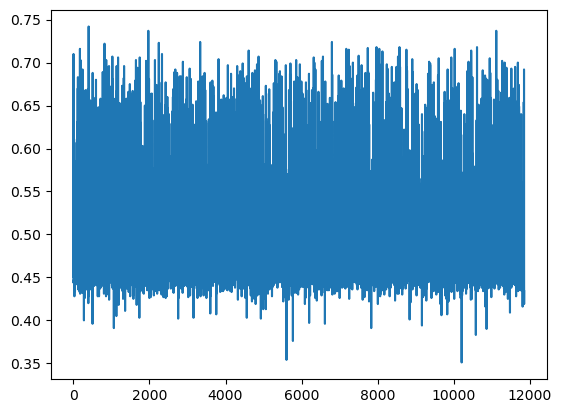

In [325]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.show()

In [326]:
output_data = {'Id': Id, 'Popularity': y_pred}
output_dataframe = pd.DataFrame(output_data)
print(output_dataframe)

output_dataframe.to_csv("./datasets/y_pred.csv", index=None)

          Id  Popularity
0      27643       0.446
1      27644       0.444
2      27645       0.447
3      27646       0.508
4      27647       0.512
...      ...         ...
11842  39485       0.692
11843  39486       0.537
11844  39487       0.508
11845  39488       0.419
11846  39489       0.434

[11847 rows x 2 columns]


### Report
* select more features, like author score, topic score and calculate kinds of rate like unique word rate.
* Use Ridge to search feature importance and delete less useful features.
* Try to use 4 single model and combine them to predict. However, the outcome is not good, I think this is because features are not idependent.